In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7500)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
        
print('GPU ready')

In [10]:
import pandas as pd

category_csv = pd.read_csv('./category/category.csv', encoding='CP949')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)

{'wine': 0, 'soju': 1, 'plate': 2, 'me': 3, 'glass': 4, 'energydrink': 5, 'case': 6, 'bottle': 7, 'be': 8}


In [11]:
from tensorflow.keras.applications import VGG16
with tf.device('/device:GPU:0'):
# VGG16은 Convolution Layer 16개, Fc Layer는 3개로 구성된 Network
    base_model = VGG16(weights= 'imagenet',
                      include_top=False,
                      input_shape=(299,299,3))

    base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [12]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = './image_data/촬영본'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(299, 299),
        classes=label_dict,
        subset='training',
        batch_size = 100,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(299, 299),
        classes=label_dict,
        subset='validation',
        batch_size = 20,
        class_mode="sparse"
    )
    train_batch_size =100
    val_batch_size =20


    print(len(trainGen.classes))
    print(len(validationGen.classes))


Found 100 images belonging to 9 classes.
Found 20 images belonging to 9 classes.
100
20


In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):

    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(299,299,3))

    model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()

    model.add(model_base)

    model.add(Flatten(input_shape=(9*9*512,)))
    

    model.add(Dense(9,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_vgg_pic.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

    epochs = 500
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=1, 
        validation_data=validationGen,
        validation_steps=1,
        verbose=1
    )




Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 373257    
Total params: 15,087,945
Trainable params: 373,257
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 2.3663 - sparse_categorical_accuracy: 0.1500WARNING:tensorflow:5 out of the last 40 calls to <function Model.make_test_function.<locals>.test_function at 0x7f70b5599dd0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.funct

Epoch 17/500
1/1 [==============================] - ETA: 0s - loss: 1.2467 - sparse_categorical_accuracy: 0.7100
Epoch 00017: val_loss improved from 1.18477 to 1.14581, saving model to ./model/recycle_vgg_pic.h5
1/1 [==============================] - 0s 445ms/step - loss: 1.2467 - sparse_categorical_accuracy: 0.7100 - val_loss: 1.1458 - val_sparse_categorical_accuracy: 0.7500
Epoch 18/500
1/1 [==============================] - ETA: 0s - loss: 1.2089 - sparse_categorical_accuracy: 0.7200
Epoch 00018: val_loss improved from 1.14581 to 1.14180, saving model to ./model/recycle_vgg_pic.h5
1/1 [==============================] - 0s 446ms/step - loss: 1.2089 - sparse_categorical_accuracy: 0.7200 - val_loss: 1.1418 - val_sparse_categorical_accuracy: 0.6500
Epoch 19/500
1/1 [==============================] - ETA: 0s - loss: 1.1967 - sparse_categorical_accuracy: 0.6700
Epoch 00019: val_loss improved from 1.14180 to 1.10124, saving model to ./model/recycle_vgg_pic.h5
1/1 [=========================

Epoch 40/500
1/1 [==============================] - ETA: 0s - loss: 0.8001 - sparse_categorical_accuracy: 0.8000
Epoch 00040: val_loss improved from 0.77193 to 0.76742, saving model to ./model/recycle_vgg_pic.h5
1/1 [==============================] - 0s 442ms/step - loss: 0.8001 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.7674 - val_sparse_categorical_accuracy: 0.9500
Epoch 41/500
1/1 [==============================] - ETA: 0s - loss: 0.8003 - sparse_categorical_accuracy: 0.8900
Epoch 00041: val_loss improved from 0.76742 to 0.73853, saving model to ./model/recycle_vgg_pic.h5
1/1 [==============================] - 0s 436ms/step - loss: 0.8003 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.7385 - val_sparse_categorical_accuracy: 1.0000
Epoch 42/500
1/1 [==============================] - ETA: 0s - loss: 0.7508 - sparse_categorical_accuracy: 0.8800
Epoch 00042: val_loss did not improve from 0.73853
1/1 [==============================] - 0s 289ms/step - loss: 0.7508 - sparse_c

Epoch 63/500
1/1 [==============================] - ETA: 0s - loss: 0.5544 - sparse_categorical_accuracy: 0.9600
Epoch 00063: val_loss improved from 0.56056 to 0.53558, saving model to ./model/recycle_vgg_pic.h5
1/1 [==============================] - 0s 432ms/step - loss: 0.5544 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.5356 - val_sparse_categorical_accuracy: 0.9500
Epoch 64/500
1/1 [==============================] - ETA: 0s - loss: 0.6058 - sparse_categorical_accuracy: 0.8900
Epoch 00064: val_loss did not improve from 0.53558
1/1 [==============================] - 0s 296ms/step - loss: 0.6058 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.5521 - val_sparse_categorical_accuracy: 1.0000
Epoch 65/500
1/1 [==============================] - ETA: 0s - loss: 0.6049 - sparse_categorical_accuracy: 0.8500
Epoch 00065: val_loss did not improve from 0.53558
1/1 [==============================] - 0s 287ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.5411 -

Epoch 109/500
1/1 [==============================] - ETA: 0s - loss: 0.3157 - sparse_categorical_accuracy: 0.9900
Epoch 00109: val_loss improved from 0.31587 to 0.29585, saving model to ./model/recycle_vgg_pic.h5
1/1 [==============================] - 0s 450ms/step - loss: 0.3157 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.2958 - val_sparse_categorical_accuracy: 1.0000
Epoch 110/500
1/1 [==============================] - ETA: 0s - loss: 0.2874 - sparse_categorical_accuracy: 0.9800
Epoch 00110: val_loss did not improve from 0.29585
1/1 [==============================] - 0s 284ms/step - loss: 0.2874 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.3244 - val_sparse_categorical_accuracy: 0.9500
Epoch 111/500
1/1 [==============================] - ETA: 0s - loss: 0.2895 - sparse_categorical_accuracy: 1.0000
Epoch 00111: val_loss improved from 0.29585 to 0.29580, saving model to ./model/recycle_vgg_pic.h5
1/1 [==============================] - 0s 436ms/step - loss: 0.2895 - spars

Epoch 132/500
1/1 [==============================] - ETA: 0s - loss: 0.2422 - sparse_categorical_accuracy: 0.9800
Epoch 00132: val_loss improved from 0.22204 to 0.21676, saving model to ./model/recycle_vgg_pic.h5
1/1 [==============================] - 0s 440ms/step - loss: 0.2422 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.2168 - val_sparse_categorical_accuracy: 1.0000
Epoch 133/500
1/1 [==============================] - ETA: 0s - loss: 0.2365 - sparse_categorical_accuracy: 0.9900
Epoch 00133: val_loss did not improve from 0.21676
1/1 [==============================] - 0s 294ms/step - loss: 0.2365 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.2273 - val_sparse_categorical_accuracy: 1.0000
Epoch 134/500
1/1 [==============================] - ETA: 0s - loss: 0.2599 - sparse_categorical_accuracy: 0.9600
Epoch 00134: val_loss did not improve from 0.21676
1/1 [==============================] - 0s 294ms/step - loss: 0.2599 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.224

Epoch 00155: early stopping


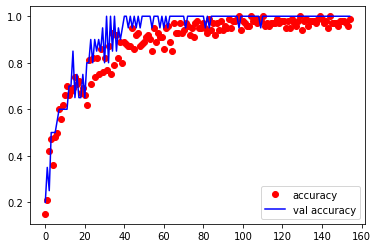

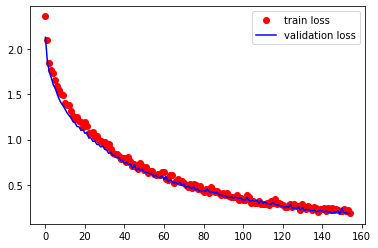

In [19]:

import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

In [2]:
#### from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model_path = './model/recycle_vgg_pic.h5'


vgg_model = tf.keras.models.load_model(model_path)


x_train, y_train= validationGen.next()
print(y_train)

#Confution Matrix and Classification Report
Y_pred = vgg_model.predict_generator(validationGen, 1)

y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
# display(confusion_matrix(validationGen.classes, y_pred))

print(y_pred)





fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
sns.heatmap(
    confusion_matrix(y_train, y_pred),
    annot = True, # 숫자표현
    fmt = '3d',    # 정수표현     
    cmap = 'Blues', # color 색상
    ax = ax,       # 그래프로 사용할 subplot
    xticklabels=category_csv['bottle_name'], 
    yticklabels=category_csv['bottle_name']
)
ax.set_xlabel('Predict')
ax.set_ylabel('Actual')
plt.show()


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]